In [95]:
import pandas as pd
import os
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import tiktoken
import string
import numpy as np
import openai
from tqdm import tqdm
import pickle
import concurrent.futures
import tenacity
from tqdm.auto import tqdm
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

openai.api_key = config.get("OPENAI", "OPENAI_API_KEY")
COMPLETIONS_MODEL = "gpt-4"
EMBEDDING_MODEL = "text-embedding-ada-002"

import time

# Define the Snowball stemmer for English
stemmer = SnowballStemmer("english")

# Define the list of stop words
stop_words = set(stopwords.words("english"))

tokenizer = tiktoken.get_encoding("cl100k_base")

# Define the maximum token length
max_length = 1024
def delete_first_and_last_10_words(text):
    words = text.split()
    return ' '.join(words[10:-10])

def preprocess_text(text):
    
    if not isinstance(text, str):
        text = str(text)
    
    text = delete_first_and_last_10_words(text)
    
    text = re.sub('\n', ' ', text, flags=re.DOTALL)

    text= re.sub('r\n', ' ', text)
    
    text = text.lower()

    # Remove numbers

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove any foreign characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Tokenize the text
    tokens = tokenizer.encode(text)

    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]

    # Truncate the tokens to the first 7500 if the total number of tokens is greater than 7500
    if len(tokens) > 2000:
        tokens = tokens[:3000]

    # Re-encode the truncated tokens into text
    truncated_text = tokenizer.decode(tokens)

    # Return the truncated text and the number of tokens
    return truncated_text, len(tokens)


# Apply the preprocess_text function to the lyrics column

df = pd.read_csv("features_df.csv")
df.sample(5)

,title,release_date,artists,album,popularity,genres,duration,explicit,track_id,artist_ids,...,speechiness,acousticness,instrumentalness,time_signature,danceability,key,loudness,valence,mode,lyrics
186,Communist Daughter,1998-02-20,Neutral Milk Hotel,In the Aeroplane Over the Sea,0,"alternative rock, anti-folk, chamber pop, elep...",117306,False,72iYfBDEF6dNVeekA8ppyB,['2ooIqOf4X2uz4mMptXCtie'],...,0.0352,0.28500,0.81300,4,0.192,7,-9.157,0.0976,1,Communist Daughter Lyrics[Intro]\nOne\n\n[Chor...
363,That Just Isn't Empirically Possible,2020-02-14,$uicideboy$,STOP STARING AT THE SHADOWS,0,"dark trap, new orleans rap, underground hip hop",123902,True,474CfF5aBSzzZLXP08FKzx,['1VPmR4DJC1PlOtd0IADAO0'],...,0.2780,0.09780,0.00000,4,0.760,7,-3.576,0.4780,0,TranslationsFrançaisMagyarTürkçeThat Just Isn’...
388,Faith,2020-04-17,LUCKI,Faith,40,"plugg, rap",107467,True,0TqNfrOY2IrpFRI2zxsMq4,['5tQMB0cuNXdCtzovGt55uD'],...,0.4190,0.12300,0.00000,4,0.878,10,-10.014,0.4880,1,"Faith Lyrics[Intro]\nMy way or the highway, of..."
434,Betrayed,2018-04-06,Lil Xan,TOTAL XANARCHY,70,"emo rap, vapor trap",187173,True,4vaxvNDaLSoD36iZX515ug,['3EXdLajEO02ziZ90P90bSW'],...,0.1180,0.43400,0.00000,4,0.821,10,-9.194,0.2410,0,"Betrayed Lyrics[Intro]\nHuh, ayy (Yeah)\nYou a..."
1117,vice city,2022-01-28,XXXTENTACION,vice city,71,"emo rap, miami hip hop",220708,True,6MOst484piqXpzPPRRe8i5,['15UsOTVnJzReFVN1VCnxy4'],...,0.1950,0.00596,0.00171,4,0.853,9,-6.843,0.3290,0,TranslationsTürkçeEspañolPolskiDeutschFrançais...


In [96]:
df = df.fillna("")
df = df.drop(df[(df["title"] == "")].index)

df["lyrics"], df["tokens"] = zip(*df["lyrics"].apply(preprocess_text))

for _, row in df.iterrows():
    if (
        len(row.lyrics.split()) < 20
        or len(row.lyrics) < 40
        or not row.lyrics.strip()
        or row.lyrics.isdigit()
    ):
        df.at[row.name, "lyrics"] = ""


df = df.drop(
    df[((df["lyrics"] == "")) | (df["title"] == "")].index)

missing_indices = []
for i, row in df.iterrows():
    lyrics, genre = row["lyrics"], row["genres"]
    if lyrics == "":
        missing_indices.append((i, "lyrics"))
    if genre == "":
        missing_indices.append((i, "genres"))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1645 entries, 0 to 1749
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             1645 non-null   object 
 1   release_date      1645 non-null   object 
 2   artists           1645 non-null   object 
 3   album             1645 non-null   object 
 4   popularity        1645 non-null   int64  
 5   genres            1645 non-null   object 
 6   duration          1645 non-null   int64  
 7   explicit          1645 non-null   bool   
 8   track_id          1645 non-null   object 
 9   artist_ids        1645 non-null   object 
 10  energy            1645 non-null   float64
 11  liveness          1645 non-null   float64
 12  tempo             1645 non-null   float64
 13  speechiness       1645 non-null   float64
 14  acousticness      1645 non-null   float64
 15  instrumentalness  1645 non-null   float64
 16  time_signature    1645 non-null   int64  


In [102]:
import concurrent.futures
import time
import pandas as pd
import openai
import tenacity
from typing import List, Dict, Tuple
from tqdm import tqdm

EMBEDDING_MODEL = "text-embedding-ada-002"


@tenacity.retry(reraise=True, stop=tenacity.stop_after_attempt(3), wait=tenacity.wait_fixed(5) + tenacity.wait_exponential(multiplier=2))
def get_embedding(text: str, model: str = EMBEDDING_MODEL, vector_length=1536):
    time.sleep(0.1)  # Wait for a tiny interval of time between each call
    result = openai.Embedding.create(
        model=model,
        input=text,
        output_format="list",
        vector_length=vector_length
    )
    return result["data"][0]["embedding"]

def get_embeddings_concurrently(texts: List[str]) -> List[List[float]]:
    embeddings = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_embedding = {executor.submit(get_embedding, text): text for text in texts}
        for future in tqdm(concurrent.futures.as_completed(future_to_embedding), total=len(texts)):
            try:
                embedding = future.result()
                embeddings.append(embedding)
            except Exception as e:
                print(f"Failed to obtain embedding: {e}")
                embeddings.append(None)
    return embeddings

lyrics_list = df["lyrics"].tolist()
genres_list = df["genres"].tolist()
unique_genres = set(df['genres'].str.split(', ').explode())
unique_genres = [value for value in unique_genres if value.strip()]
unique_genres

embeddings_genres = get_embeddings_concurrently(unique_genres)
embeddings_lyrics = get_embeddings_concurrently(df["lyrics"].tolist())

100%|███████████████████████████████████████| 1645/1645 [00:37<00:00, 43.96it/s]


In [160]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(embeddings):
    similarity_matrix = cosine_similarity(embeddings)
    return similarity_matrix


embedding_genres = [np.array(embedding) for embedding in embeddings_genres]
embedding_lyrics = [np.array(embedding) for embedding in embeddings_lyrics]

combined_embeddings = embedding_lyrics + embedding_genres



similarity_matrix = calculate_similarity(combined_embeddings)

similarity_matrix = 1 - similarity_matrix




In [189]:
df_genres = pd.DataFrame()
df_genres["embeddings"] = embeddings_genres
df_genres["genres"] = unique_genres


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448 entries, 0 to 447
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   embeddings  448 non-null    object
 1   genres      448 non-null    object
dtypes: object(2)
memory usage: 7.1+ KB


In [162]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


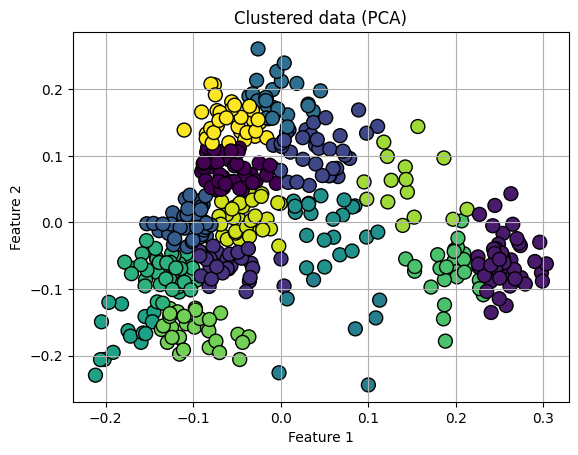

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


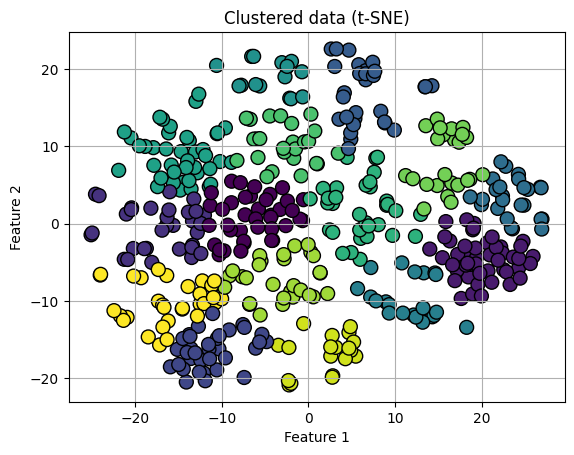

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


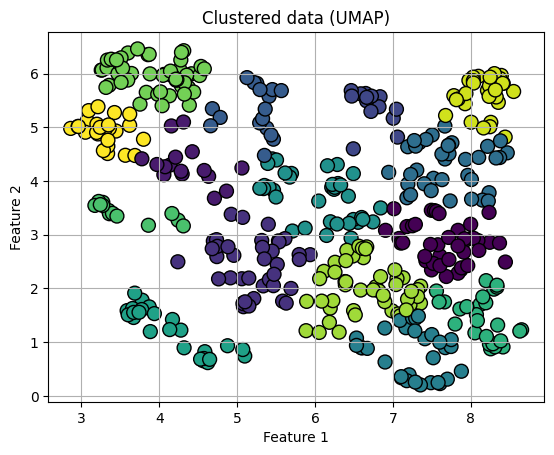

In [180]:
def plot_clustering(X, clusters, title):
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', edgecolor='k', s=100)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.grid()
    plt.show()


    
X_scaled = df_genres

# Step 3: Feature Selection - Variance Threshold
#selector = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))  
#X_high_variance = selector.fit_transform(X_scaled)
#selected_features = selector.get_support()

kmeans = KMeans(n_clusters=15, random_state=42)


# Step 3C: Feature Selection - PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
clusters_pca = kmeans.fit_predict(X_pca)
plot_clustering(X_pca, clusters_pca, 'Clustered data (PCA)')

# Step 3D: Feature Selection - t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
clusters_tsne = kmeans.fit_predict(X_tsne)
plot_clustering(X_tsne, clusters_tsne, 'Clustered data (t-SNE)')


reducer = UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
clusters_UMAP = kmeans.fit_predict(X_umap)
plot_clustering(X_umap, clusters_UMAP, 'Clustered data (UMAP)')



In [181]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

datasets = [
    (X_pca, clusters_pca, "PCA"),
    (X_tsne, clusters_tsne, "t-SNE"),
    (X_umap, clusters_UMAP, "UMAP"),
]

print("Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Index | Technique")
print("-------------------------------------------------------------------------")
for X_transformed, clusters, technique in datasets:
    silhouette = silhouette_score(X_transformed, clusters)
    davies_bouldin = davies_bouldin_score(X_transformed, clusters)
    calinski_harabasz = calinski_harabasz_score(X_transformed, clusters)
    print(f"{silhouette:.4f}          | {davies_bouldin:.4f}              | {calinski_harabasz:.4f}                | {technique}")

Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Index | Technique
-------------------------------------------------------------------------
0.3559          | 0.8603              | 592.4781                | PCA
0.3622          | 0.8254              | 475.0329                | t-SNE
0.4290          | 0.7264              | 596.0893                | UMAP


In [167]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Load the Iris dataset
X = data
y = clusters_UMAP

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Filter Methods
# Pearson's Correlation Coefficient
corr_matrix = np.abs(np.corrcoef(X_scaled, y, rowvar=False)[:6, 6])
print("Pearson Correlation Coefficient:", corr_matrix)

# Mutual Information
mi_selector = SelectKBest(mutual_info_classif, k=2)
X_mi = mi_selector.fit_transform(X_scaled, y)
print("Mutual Information selected features:", mi_selector.get_support())

# 2. Wrapper Methods
# Recursive Feature Elimination with Linear Regression estimator
lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=2)
X_rfe = rfe.fit_transform(X_scaled, y)
print("RFE with Linear Regression selected features:", rfe.get_support())

# 3. Embedded Methods
# LASSO Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_scaled, y)
lasso_selector = SelectFromModel(lasso)
X_lasso = lasso_selector.fit_transform(X_scaled, y)
print("LASSO Regression selected features:", lasso_selector.get_support())

# Random Forests
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)
rf_selector = SelectFromModel(rf, max_features=2)
X_rf = rf_selector.fit_transform(X_scaled, y)
print("Random Forest selected features:", rf_selector.get_support())

# 4. Hybrid Methods
# Filter method followed by embedded method
# First, select high variance features (here we do not remove any)
thresh = .8 * (1 - .8)
variance_selector = VarianceThreshold(threshold=thresh)
X_high_variance = variance_selector.fit_transform(X_scaled)

# Then, perform feature selection using Random Forests on the remaining features
rf_hybrid = RandomForestClassifier(random_state=42)
rf_hybrid.fit(X_high_variance, y)
hybrid_selector = SelectFromModel(rf_hybrid, max_features=2)
X_hybrid = hybrid_selector.fit_transform(X_high_variance, y)
print("Hybrid Method selected features:", hybrid_selector.get_support())

Pearson Correlation Coefficient: [0.13523327 0.16426331 0.16861311 0.23853707 0.24221824 0.3673018 ]



KeyboardInterrupt



In [ ]:
from sklearn.cluster import SpectralClustering
n_clusters = 15  # set the number of clusters
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10)


clusters_high_variance = spectral.fit_predict(X_high_variance)
plot_clustering(X_high_variance, clusters_high_variance, 'Clustered data (high variance features)')

# Step 3B: Feature Selection - Highly Correlated Features
correlation_matrix = np.abs(np.corrcoef(X_scaled, rowvar=False))
np.fill_diagonal(correlation_matrix, 0)
max_corr = correlation_matrix.max(axis=1)
mask = max_corr < 0.9  # Pick a threshold to decide which features to include

X_low_corr = X_scaled[:, mask]

clusters_low_corr = spectral.fit_predict(X_low_corr)
plot_clustering(X_low_corr, clusters_low_corr, 'Clustered data (low correlated features)')

# Step 3C: Feature Selection - PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
clusters_pca = spectral.fit_predict(X_pca)
plot_clustering(X_pca, clusters_pca, 'Clustered data (PCA)')

# Step 3D: Feature Selection - t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
clusters_tsne = spectral.fit_predict(X_tsne)
plot_clustering(X_tsne, clusters_tsne, 'Clustered data (t-SNE)')


reducer = UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
clusters_UMAP = spectral.fit_predict(X_umap)
plot_clustering(X_umap, clusters_UMAP, 'Clustered data (UMAP)')



In [153]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

datasets = [
    (X_high_variance, clusters_high_variance, "High Variance Features"),
    (X_low_corr, clusters_low_corr, "Low Correlated Features"),
    (X_pca, clusters_pca, "PCA"),
    (X_tsne, clusters_tsne, "t-SNE"),
    (X_umap, clusters_UMAP, "UMAP"),
]

print("Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Index | Technique")
print("-------------------------------------------------------------------------")
for X_transformed, clusters, technique in datasets:
    silhouette = silhouette_score(X_transformed, clusters)
    davies_bouldin = davies_bouldin_score(X_transformed, clusters)
    calinski_harabasz = calinski_harabasz_score(X_transformed, clusters)
    print(f"{silhouette:.4f}          | {davies_bouldin:.4f}              | {calinski_harabasz:.4f}                | {technique}")

Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Index | Technique
-------------------------------------------------------------------------
0.0539          | 3.0894              | 8.6773                | High Variance Features
0.0537          | 3.1437              | 8.6238                | Low Correlated Features
0.3159          | 0.8826              | 530.4968                | PCA
0.3460          | 0.7754              | 426.6968                | t-SNE
0.3847          | 0.7335              | 465.1702                | UMAP


/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


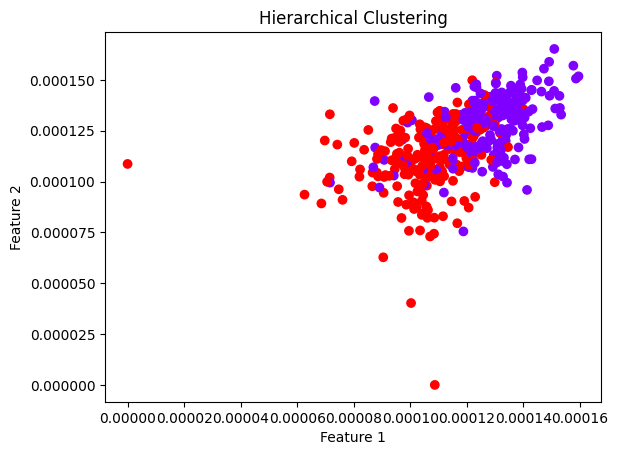

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

# create a sample dataset
X = similarity_matrix

distances = pdist(X)
linkage_matrix = linkage(distances, method='ward')
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model.fit(X)

# plot the clusters
plt.scatter(X[:,0], X[:,1], c=model.labels_, cmap='rainbow')
plt.title('Hierarchical Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

